#  Условие задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## Задачи проекта
### [Шаг 1. Анализ данных](#step1)

### [Шаг 2. Подготовка данных](#step2)

### [Шаг 3. Обучение моделей](#step3)

### [Шаг 4. Вывод](#step4)


# Этапы выполнения проекта

## Шаг 1. Подготовим данные. <a id='step1'></a>

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats as st

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")



In [2]:
df_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
df_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
df_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
df_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
df_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
df_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
df_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')



In [3]:
datasets = {'Данные об электродах': df_arc, 
            'Данные о подаче сыпучих материалов (объём)': df_bulk, 
            'Данные о подаче сыпучих материалов (время)': df_bulk_time,
            'Данные о продувке сплава газом': df_gas,
            'Результаты измерения температуры': df_temp,
            'Данные о проволочных материалах (объём)': df_wire,
            'Данные о проволочных материалах (время)': df_bulk_time,
           }

In [4]:
def getInfo(df):
    display(df.head())
    display(df.sample(5))
    print(df.info())
    display(df.describe())
    print('Количество дубликатов:',df.duplicated().sum())
    print('\n')


In [5]:
for key, value in datasets.items():
    print(key)
    getInfo(value)

Данные об электродах


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9835,2131,2019-07-24 11:57:29,2019-07-24 12:00:15,0.576427,0.438227
14743,3210,2019-08-31 04:09:43,2019-08-31 04:12:49,0.614825,0.529074
6974,1513,2019-06-26 22:31:07,2019-06-26 22:32:12,0.201733,0.166756
14723,3204,2019-08-31 00:31:07,2019-08-31 00:32:40,0.305474,0.393975
41,10,2019-05-03 16:21:38,2019-05-03 16:23:48,0.475732,0.399615


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Количество дубликатов: 0


Данные о подаче сыпучих материалов (объём)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1142,1190,NaN,NaN,NaN,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,261.0,NaN,NaN,NaN
117,130,73.0,NaN,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.0,NaN,259.0,204.0
658,690,48.0,NaN,NaN,NaN,NaN,224.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,153.0,NaN
943,988,NaN,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.0,NaN,157.0,102.0
2194,2273,NaN,NaN,NaN,NaN,NaN,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.0,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Количество дубликатов: 0


Данные о подаче сыпучих материалов (время)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
2438,2530,NaN,NaN,2019-08-07 03:04:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-07 02:51:37,NaN,2019-08-07 02:51:37,2019-08-07 02:51:37
362,388,NaN,NaN,2019-05-17 23:35:09,2019-05-17 23:45:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-17 23:26:34,NaN,2019-05-17 23:26:34,2019-05-17 23:26:34
2942,3051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-26 01:46:58,NaN,2019-08-26 01:39:35,NaN,2019-08-26 01:39:35,2019-08-26 01:39:35
2396,2487,NaN,NaN,NaN,NaN,NaN,2019-08-05 15:28:05,NaN,NaN,NaN,NaN,2019-08-05 15:28:05,2019-08-05 15:02:20,NaN,2019-08-05 15:02:20,2019-08-05 15:02:20
1222,1272,NaN,NaN,NaN,2019-06-18 08:10:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-18 07:58:53,NaN,2019-06-18 07:58:53,2019-06-18 07:58:53


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Количество дубликатов: 0


Данные о продувке сплава газом


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,Газ 1
2403,2406,9.535107
353,356,32.651546
1398,1401,11.762223
793,796,10.670498
1675,1678,25.296227


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Количество дубликатов: 0


Результаты измерения температуры


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


,key,Время замера,Температура
4387,873,2019-06-04 18:32:35,1598.0
14367,2917,2019-08-21 08:00:37,1547.0
4773,953,2019-06-07 15:13:47,1537.0
15881,3237,2019-08-31 23:01:16,NaN
4321,860,2019-06-04 09:35:06,1605.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Количество дубликатов: 0


Данные о проволочных материалах (объём)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
2690,2831,105.050400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1541,1620,115.128006,65.115440,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994,2091,103.084801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
877,937,142.084793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2638,2772,95.047676,40.173119,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Количество дубликатов: 0


Данные о проволочных материалах (время)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1146,1194,NaN,NaN,2019-06-15 14:30:37,2019-06-15 14:30:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-15 14:21:44,NaN,2019-06-15 14:21:44,2019-06-15 14:21:44
2550,2648,NaN,NaN,2019-08-11 11:49:39,NaN,NaN,NaN,NaN,NaN,2019-08-11 12:13:43,NaN,NaN,NaN,NaN,2019-08-11 11:33:27,NaN
2742,2845,NaN,NaN,NaN,NaN,NaN,2019-08-18 14:57:29,NaN,NaN,NaN,NaN,NaN,2019-08-18 14:24:38,NaN,2019-08-18 14:24:38,2019-08-18 14:24:38
1798,1860,NaN,NaN,2019-07-08 09:34:26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-08 09:30:11,NaN,2019-07-08 09:30:11,2019-07-08 09:30:11
467,493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-21 17:52:51,NaN,NaN,NaN,2019-05-21 17:45:57,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Количество дубликатов: 0




#### Краткий вывод
<p>В данных об электродах содержится номер партии, начало и конец нагрева, активная и реактивная мощности. В данных о подаче сыпучих материалов (объем) указано, какой именно сыпучий материал использовался, для какой партии и в каком объеме. В датасете времени подачи материалов имеется информация о времени. <b>Важно заметить</b>, что количество пропусков в этих двух таблицах одинаково, что говорит о корректности их заполнения. Большое количество пропусков в них - нормально. Данные о продувке сплава газом содержат номер партии и объем газ, а датасет с результатами измерения температуры - состояние металла после ввода легирующих добавок. Стоит отметить, что в датасете с температурами отсутсвует часть данных в столбце "Температура". По данным проволочных материалов есть два датасета - с объемом и временем. <b>Важно заметить</b>, что тут количество строк и пропусков различается, и это требует обработки.</p>
<p>Также в датасетах имеются следующие проблемы:</p>
<ul>
<li>неверный формат даты (например в данных об электродах, о подаче сыпучих материалов,результатах измерения температуры, проволочных материалах)</li>
<li>выброс в данных: минимальное значение реактивной мощности -715 в данных об электродах. </li>
</ul>
<p>Рассмотрим датасет с электродами, газами, температурой и проволочными материалами подробнее.Подготовим функцию для визуализации.</p>

In [6]:
def customPlot(data,parametr):
    fig = plt.figure(figsize=(15, 6), dpi= 80)
    grid = plt.GridSpec(5, 5, hspace=0.1, wspace=0.2)
    ax_1 = fig.add_subplot(grid[:-1, :-1])
    ax_2 = fig.add_subplot(grid[:-1, -1])  
    sns.distplot(data[parametr], ax=ax_1)
    sns.boxplot(data[parametr], ax=ax_2)
    ax_1.grid(axis='y')
    ax_1.set(title='График '+parametr)
    ax_1.axvline(np.mean(data[parametr]),color='g', linestyle='--', label='Среднее')
    ax_1.axvline(np.median(data[parametr]),color='r', linestyle='-', label='Медиана')
    ax_1.legend()
    fig.show()
    

###  Исследование данных 
#### Данные об электродах: df_arc

In [7]:
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'])
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'])

In [8]:
df_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


In [9]:
df_arc['key'].value_counts()

2108    16
1689    15
1513    15
2567    14
322     13
        ..
614      1
1914     1
2025     1
2795     1
1568     1
Name: key, Length: 3214, dtype: int64

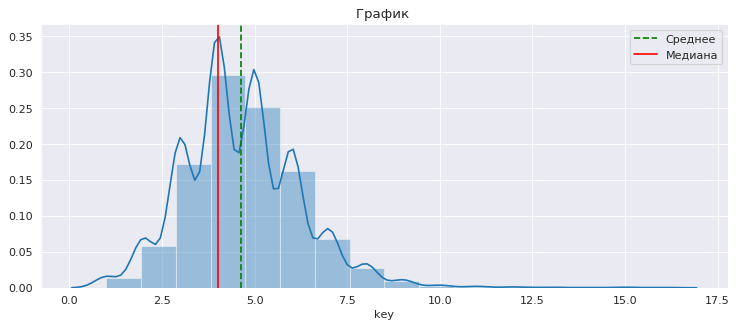

In [10]:
fig = plt.figure(figsize=(15, 6), dpi= 80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)
ax = fig.add_subplot(grid[:-1, :-1])
sns.distplot(df_arc['key'].value_counts(), bins=16)
ax.set(title='График ')
ax.axvline(np.mean(df_arc['key'].value_counts()),color='g', linestyle='--', label='Среднее')
ax.axvline(np.median(df_arc['key'].value_counts()),color='r', linestyle='-', label='Медиана')
ax.legend()
fig.show()
    

Максимальное количество итераций для партии - 16. Среднее значение - чуть больше 4.

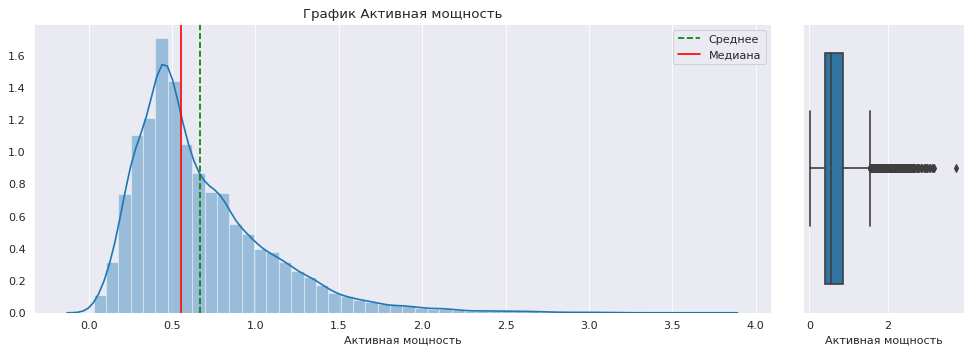

In [11]:
customPlot(df_arc,'Активная мощность')


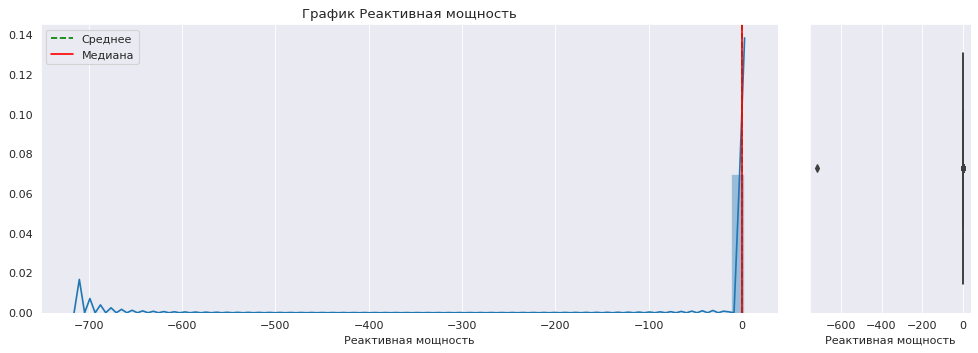

In [12]:
customPlot(df_arc,'Реактивная мощность')


Удалим выброс в столбце реактивная мощность и посмотрим на распределение повторно. 

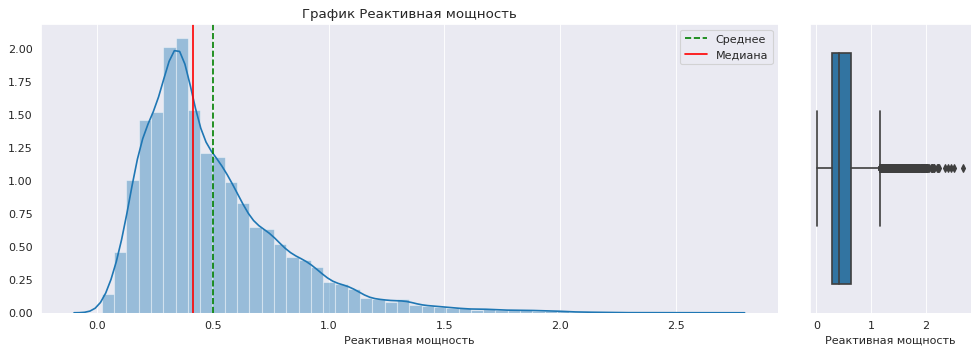

In [13]:
df_arc = df_arc[df_arc['Реактивная мощность'] >= 0]
customPlot(df_arc,'Реактивная мощность')

Проверим зависимость двух столбцов. 

In [14]:
print('Корреляция активной и реактивной мощности', df_arc['Активная мощность'].corr(df_arc['Реактивная мощность']))


Корреляция активной и реактивной мощности 0.9631819131519803


Использование обоих признаковы для машинного обучения может негативно сказаться на результатах (модель может переобучиться). Поэтому рассчитаем полною мощность по формуле:
    $$ S=\sqrt{P^2+Q^2} $$
где: $P$ — активная мощность, $Q$ — реактивная мощность

In [15]:
def full_power(row):
    full_power = math.sqrt(row['Активная мощность']**2 + row['Реактивная мощность']**2)
    return full_power
df_arc['Полная мощность'] = df_arc.apply(full_power, axis=1)

In [16]:
df_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239
...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,0.640648
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,0.855559
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,0.874560
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,0.264489


### Вывод:
Изучили датасет, преобразовали типы данных на datetime в нужных столбцах, избавились от выбросов и расчитали полную мощность. Перейдем к анализу следующих данных. 

#### Данные о газе

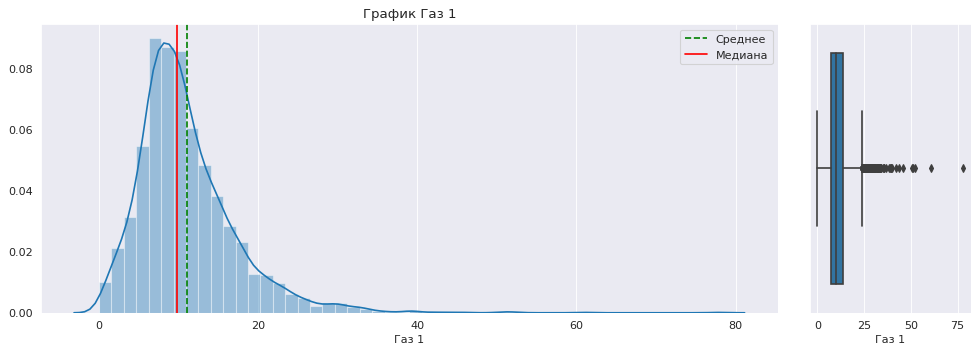

In [17]:
customPlot(df_gas,'Газ 1')

In [18]:
df_gas.info()
display(df_gas.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Видим, что данные все заполнены, распределение величин нормальное. 

#### Данные о температуре

In [19]:
df_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


In [20]:
df_temp = df_temp[df_temp['Температура']>0]

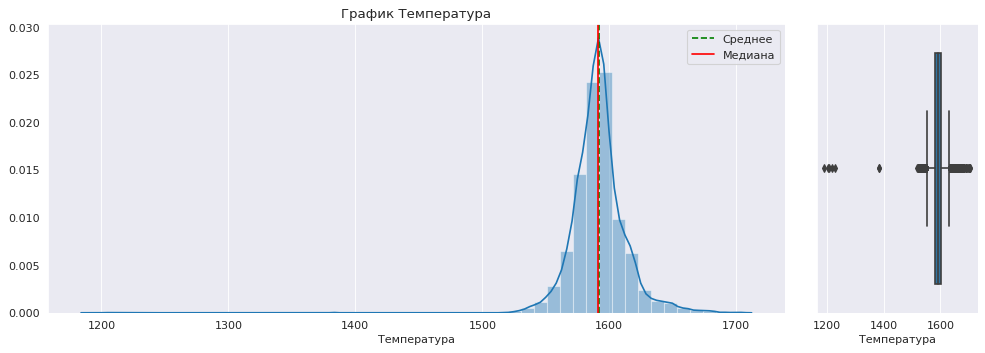

In [21]:
customPlot(df_temp,'Температура')

In [22]:
df_temp.info()
display(df_temp.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13006 entries, 0 to 15902
Data columns (total 3 columns):
key             13006 non-null int64
Время замера    13006 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 406.4+ KB


,key,Температура
count,13006.000000,13006.000000
mean,1328.447793,1591.840920
std,804.740001,21.375851
min,1.000000,1191.000000
25%,638.000000,1581.000000
50%,1315.000000,1591.000000
75%,1977.750000,1601.000000
max,3241.000000,1705.000000


Заметим, что часть данных по температуре отсутствует. Время нужно привести к нужному формату. 

In [23]:
df_temp['Время замера'] = pd.to_datetime(df_temp['Время замера'])

In [24]:
display(df_temp[df_temp['Температура'].isnull()].head(10))
display(df_temp[df_temp['Температура'].isnull()].tail())

,key,Время замера,Температура


,key,Время замера,Температура


В датасете имеются пропуски в значении температуры начиная с 2500 номера партии. Время замера привели к нужному формату. График распределения имеет выбросы. Определим позже, что будем делать с ним. 

<h3>Выполненные работы</h3>
<ul>
<li>Загрузка и изучение данных.</li>
<li>Обработка типов данных для некоторых датасетов.</li>
<li>Удаление аномальных значений.</li>
<li>Расчитали полную мощность для первого датасета.</li>
<li>Выявили пустые значения по температуре.</li>
</ul>
<h3>План работ </h3>
<ul>
<li>Объединим данные в один датасет, сделав срез до 2500 партии, разбив значение температуры на два столбца - первый замер температуры и последний замер, и сгруппировав данные по партиям. </li>
<li>Избавимся от выбросов</li>
<li>Проведем машстабирование признаков, поскольку данные измеряются в разных величинах с большими разбросами</li>
<li>Разделим выборку на тестовую и обучающую</li>

    

## Предобработка данных

Сделаем срез данных до 2499 номера партии, поскольку начиная 2500 отсутсвует информация по температуре.

In [25]:
def makeSlice(df):
    df = df[df['key'] < 2500]
    return df
df_arc = makeSlice(df_arc)
df_bulk = makeSlice(df_bulk)
df_bulk_time = makeSlice(df_bulk_time)
df_gas = makeSlice(df_gas)
df_temp = makeSlice(df_temp )
df_wire = makeSlice(df_wire)
df_wire_time = makeSlice(df_wire_time)

В датасете об электродах расчитает время продува дугой.

In [26]:
df_arc['Время нагрева дугой'] = df_arc['Конец нагрева дугой']-df_arc['Начало нагрева дугой']
df_arc['Время нагрева дугой'] = df_arc['Время нагрева дугой'].dt.seconds
display(df_arc.head())
display(df_arc['Время нагрева дугой'].describe())

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева дугой
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,148


count    11448.000000
mean       172.936059
std         98.608908
min         11.000000
25%        108.000000
50%        147.000000
75%        218.000000
max        907.000000
Name: Время нагрева дугой, dtype: float64

<p>Заметим, что очень большой разброс в значениях - от 11 секунд до 907. </p>
<p>Далее проведем группировку данных по количеству итераций.</p>


In [27]:
df_arc[df_arc['key'] == 2]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева дугой
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043,0.521549,137
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914,1.574162,338
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281,0.577638,126
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874,0.975867,210


In [28]:
df_arc_count = df_arc.pivot_table(index=['key'], aggfunc='size').to_frame().reset_index()

In [29]:
df_arc_count

,key,0
0,1,5
1,2,4
2,3,5
3,4,4
4,5,4
...,...,...
2470,2495,4
2471,2496,6
2472,2497,3
2473,2498,5


In [30]:
df_arc = df_arc.merge(df_arc_count, how = 'left', on = 'key')
df_arc = df_arc.rename(columns={0: 'Количество итераций'})

In [31]:
df_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева дугой,Количество итераций
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,228,5
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,185,5
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,172,5
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,365,5
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,148,5
...,...,...,...,...,...,...,...,...
11443,2498,2019-08-06 02:19:43,2019-08-06 02:20:24,0.180213,0.116065,0.214355,41,5
11444,2499,2019-08-06 02:32:56,2019-08-06 02:38:08,1.425867,1.043338,1.766819,312,4
11445,2499,2019-08-06 02:41:09,2019-08-06 02:44:34,0.978407,0.627803,1.162504,205,4
11446,2499,2019-08-06 02:46:03,2019-08-06 02:50:58,1.381264,0.894252,1.645472,295,4


In [32]:
df_arc_pivot = pd.pivot_table(df_arc, values=['Полная мощность', 'Время нагрева дугой'], index=['key','Количество итераций'],
                          aggfunc={'Полная мощность': np.sum,'Время нагрева дугой': np.sum})
df_arc_pivot = df_arc_pivot.reset_index(level=[0,1])

In [33]:
df_arc_pivot

,key,Количество итераций,Время нагрева дугой,Полная мощность
0,1,5,1098,5.826395
1,2,4,811,3.649216
2,3,5,655,2.989534
3,4,4,741,3.814962
4,5,4,869,4.035758
...,...,...,...,...
2470,2495,4,723,3.986869
2471,2496,6,940,5.057033
2472,2497,3,569,2.885017
2473,2498,5,750,4.143749


Проведем преобразования в датасете df_temp:
 - проверим полноту данных 
 - рассчитаем начальную и конечную температуру по партии
 - удалим информацию по партиям, где есть только один замер (поскольку мы сможем расчитать )

In [34]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12267 entries, 0 to 12266
Data columns (total 3 columns):
key             12267 non-null int64
Время замера    12267 non-null datetime64[ns]
Температура     12267 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 383.3 KB


In [35]:
df_temp = df_temp.groupby(by = 'key').agg(['first', 'last']).reset_index()
df_temp.columns = df_temp.columns.droplevel()
df_temp.columns = ['key', 'Первое время замера', 'Последнее время замера', 'Начальная температура', 'Конечная температура']

In [36]:
df_temp

,key,Первое время замера,Последнее время замера,Начальная температура,Конечная температура
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0
...,...,...,...,...,...
2472,2495,2019-08-06 00:35:45,2019-08-06 00:54:42,1570.0,1591.0
2473,2496,2019-08-06 01:02:54,2019-08-06 01:29:52,1554.0,1591.0
2474,2497,2019-08-06 01:41:53,2019-08-06 01:53:50,1571.0,1589.0
2475,2498,2019-08-06 02:03:49,2019-08-06 02:25:31,1591.0,1594.0


In [37]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2477 entries, 0 to 2476
Data columns (total 5 columns):
key                       2477 non-null int64
Первое время замера       2477 non-null datetime64[ns]
Последнее время замера    2477 non-null datetime64[ns]
Начальная температура     2477 non-null float64
Конечная температура      2477 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 96.9 KB


In [38]:
len(df_temp['key'].unique())

2477

### Объединим данные в одну таблицу

In [39]:
df = (df_temp.merge(df_arc_pivot, how = 'left', on = 'key')
                 .merge(df_wire, how = 'left', on = 'key')
                 .merge(df_bulk, how = 'left', on = 'key')
                 .merge(df_gas, how = 'left', on = 'key')
       )

df = df.fillna(0)

In [40]:
df

,key,Первое время замера,Последнее время замера,Начальная температура,Конечная температура,Количество итераций,Время нагрева дугой,Полная мощность,Wire 1,Wire 2,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,5.0,1098.0,5.826395,60.059998,0.00000,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,4.0,811.0,3.649216,96.052315,0.00000,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,5.0,655.0,2.989534,91.160157,0.00000,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,4.0,741.0,3.814962,89.063515,0.00000,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,4.0,869.0,4.035758,89.238236,9.11456,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2472,2495,2019-08-06 00:35:45,2019-08-06 00:54:42,1570.0,1591.0,4.0,723.0,3.986869,89.150879,0.00000,...,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735
2473,2496,2019-08-06 01:02:54,2019-08-06 01:29:52,1554.0,1591.0,6.0,940.0,5.057033,114.179527,0.00000,...,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616
2474,2497,2019-08-06 01:41:53,2019-08-06 01:53:50,1571.0,1589.0,3.0,569.0,2.885017,94.086723,9.04800,...,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699
2475,2498,2019-08-06 02:03:49,2019-08-06 02:25:31,1591.0,1594.0,5.0,750.0,4.143749,118.110717,0.00000,...,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 33 columns):
key                       2477 non-null int64
Первое время замера       2477 non-null datetime64[ns]
Последнее время замера    2477 non-null datetime64[ns]
Начальная температура     2477 non-null float64
Конечная температура      2477 non-null float64
Количество итераций       2477 non-null float64
Время нагрева дугой       2477 non-null float64
Полная мощность           2477 non-null float64
Wire 1                    2477 non-null float64
Wire 2                    2477 non-null float64
Wire 3                    2477 non-null float64
Wire 4                    2477 non-null float64
Wire 5                    2477 non-null float64
Wire 6                    2477 non-null float64
Wire 7                    2477 non-null float64
Wire 8                    2477 non-null float64
Wire 9                    2477 non-null float64
Bulk 1                    2477 non-null float64
Bulk 2           

Рассмотрим корреляцию признаков, и удалим лишние столбцы. 

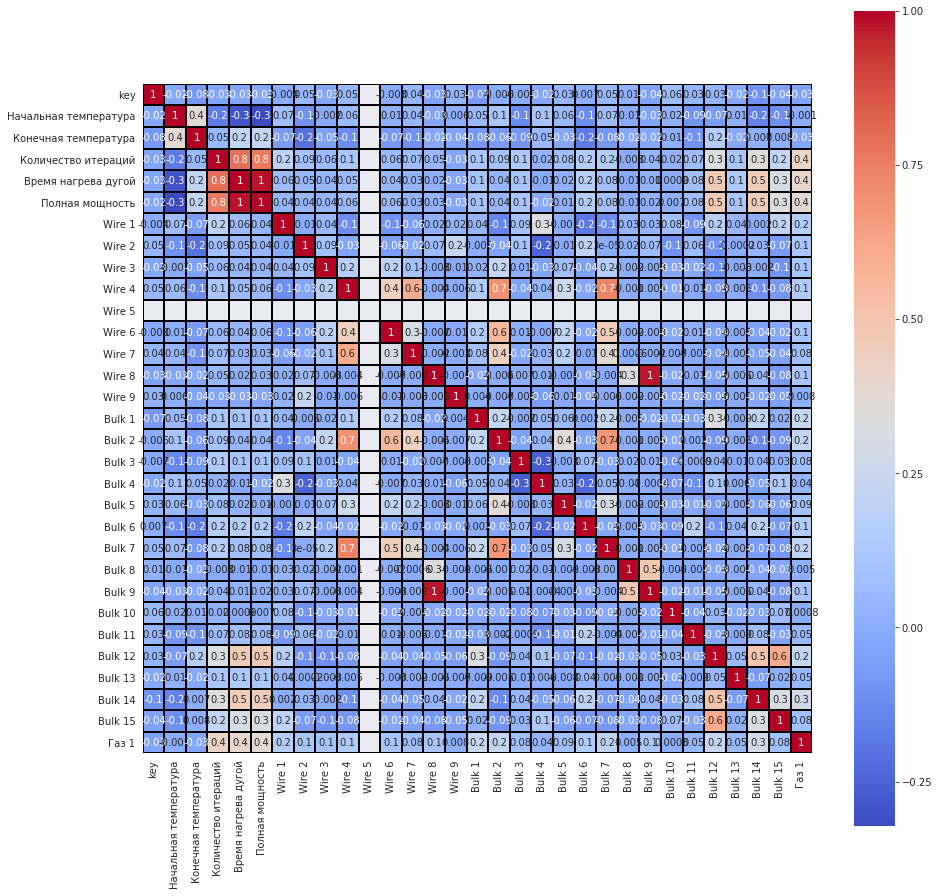

In [42]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), annot = True, fmt='.1g', square=True,cmap= 'coolwarm', linewidths=1, linecolor='black')

Как видно, количество итераций коррелирует с временем нагрева и полной мощностью. Некоторые проволочные материалы также обладают зависимостью между собой. На данном шаге удалим следующие столбцы:
- время нагрева
- первое время замера
- последнее время замера
- номер партии

In [43]:
df = df.drop(['key','Первое время замера','Последнее время замера','Время нагрева дугой'], axis = 1)

In [44]:
df

,Начальная температура,Конечная температура,Количество итераций,Полная мощность,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1
0,1571.0,1613.0,5.0,5.826395,60.059998,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
1,1581.0,1602.0,4.0,3.649216,96.052315,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
2,1596.0,1599.0,5.0,2.989534,91.160157,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
3,1601.0,1625.0,4.0,3.814962,89.063515,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
4,1576.0,1602.0,4.0,4.035758,89.238236,9.11456,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2472,1570.0,1591.0,4.0,3.986869,89.150879,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735
2473,1554.0,1591.0,6.0,5.057033,114.179527,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616
2474,1571.0,1589.0,3.0,2.885017,94.086723,9.04800,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699
2475,1591.0,1594.0,5.0,4.143749,118.110717,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657


Переименуем столбцы и перейдем к созданию обучающей и тестовой выборки. 

In [45]:
df = df.rename(columns={'Начальная температура': 'Start_temp',
                        'Конечная температура': 'End_temp',
                        'Полная мощность': 'Power',
                        'Количество итераций':'Iterations',
                        'Газ 1': 'Gas'})

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 29 columns):
Start_temp    2477 non-null float64
End_temp      2477 non-null float64
Iterations    2477 non-null float64
Power         2477 non-null float64
Wire 1        2477 non-null float64
Wire 2        2477 non-null float64
Wire 3        2477 non-null float64
Wire 4        2477 non-null float64
Wire 5        2477 non-null float64
Wire 6        2477 non-null float64
Wire 7        2477 non-null float64
Wire 8        2477 non-null float64
Wire 9        2477 non-null float64
Bulk 1        2477 non-null float64
Bulk 2        2477 non-null float64
Bulk 3        2477 non-null float64
Bulk 4        2477 non-null float64
Bulk 5        2477 non-null float64
Bulk 6        2477 non-null float64
Bulk 7        2477 non-null float64
Bulk 8        2477 non-null float64
Bulk 9        2477 non-null float64
Bulk 10       2477 non-null float64
Bulk 11       2477 non-null float64
Bulk 12       2477 non-null f

In [47]:
train, test = train_test_split(df, test_size = .30, random_state = 12345)

In [48]:
numeric = train.columns

numeric = [i for i in numeric if i not in ('End_temp')]
print(numeric)

scaler = StandardScaler()
scaler.fit(train[numeric])

train[numeric] = scaler.transform(train[numeric])
test[numeric] = scaler.transform(test[numeric])

['Start_temp', 'Iterations', 'Power', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'Gas']


In [49]:
train

,Start_temp,End_temp,Iterations,Power,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Gas
242,0.175624,1575.0,-0.977914,-1.208762,-1.069275,2.080848,-0.104742,-0.064644,0.0,-0.109354,...,-0.072907,-0.024028,-0.072245,-0.240994,-0.195953,-1.248488,-0.065575,1.217884,-1.283255,-0.238344
942,-0.663286,1585.0,-0.977914,-0.902470,-1.773340,3.433751,-0.104742,-0.064644,0.0,-0.109354,...,-0.072907,-0.024028,-0.072245,-0.240994,-0.195953,-1.248488,-0.065575,-1.740973,-1.283255,-1.698151
1012,-1.065963,1608.0,-0.361202,0.757873,-0.778199,-0.529989,-0.104742,-0.064644,0.0,-0.109354,...,-0.072907,-0.024028,-0.072245,-0.240994,1.089353,1.014311,-0.065575,1.957598,1.083798,0.803915
2427,0.813196,1595.0,-0.977914,-0.526173,0.682861,0.197227,-0.104742,-0.064644,0.0,-0.109354,...,-0.072907,-0.024028,-0.072245,-0.240994,-0.195953,0.395479,-0.065575,-0.367218,1.359571,-1.153623
1263,1.954113,1584.0,-0.977914,-1.673863,1.045565,-0.529989,-0.104742,-0.064644,0.0,-0.109354,...,-0.072907,-0.024028,-0.072245,-0.240994,-0.195953,-1.248488,-0.065575,-1.740973,-1.283255,0.391595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2153,-1.468640,1587.0,0.872222,1.439445,-0.033165,-0.529989,-0.104742,-0.064644,0.0,-0.109354,...,-0.072907,-0.024028,-0.072245,-0.240994,-0.195953,1.389361,-0.065575,0.724741,1.187213,0.145585
546,0.880309,1591.0,0.255510,-0.256317,1.089178,-0.529989,-0.104742,-0.064644,0.0,-0.109354,...,-0.072907,-0.024028,-0.072245,-0.240994,-0.195953,0.026681,-0.065575,0.078959,1.037836,-0.423419
382,0.074955,1603.0,-0.361202,0.037674,0.349760,-0.529989,-0.104742,-0.064644,0.0,-0.109354,...,-0.072907,-0.024028,-0.072245,-0.240994,-0.195953,-0.273359,-0.065575,-0.097164,-1.283255,0.612070
2177,-0.260609,1578.0,-2.211338,-1.712144,-1.285748,1.163816,-0.104742,-0.064644,0.0,-0.109354,...,-0.072907,-0.024028,-0.072245,-0.240994,3.659967,-0.392125,-0.065575,-0.285028,-0.042276,-0.728360


In [50]:
test

,Start_temp,End_temp,Iterations,Power,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Gas
1027,-1.468640,1593.0,0.255510,0.674389,0.831472,-0.529989,-0.104742,-0.064644,0.0,-0.109354,...,-0.072907,-0.024028,-0.072245,-0.240994,-0.195953,1.026813,-0.065575,0.713000,0.888459,-0.434921
1911,-0.562617,1604.0,2.722358,2.203094,-0.141401,-0.529989,-0.104742,-0.064644,0.0,-0.109354,...,-0.072907,-0.024028,-0.072245,-0.240994,4.236139,0.107941,-0.065575,1.887149,-0.088238,0.868360
1671,-0.159940,1586.0,0.255510,-0.686302,0.387424,0.982694,-0.104742,-0.064644,0.0,-0.109354,...,-0.072907,-0.024028,-0.072245,-0.240994,-0.195953,-1.248488,-0.065575,-0.578565,-1.283255,-0.186627
1357,-1.133076,1572.0,1.488934,0.885863,-1.095376,-0.529989,-0.104742,-0.064644,0.0,-0.109354,...,-0.072907,-0.024028,-0.072245,-0.240994,-0.195953,0.039182,-0.065575,0.666034,-0.099728,-0.160474
1352,-0.998850,1576.0,2.105646,1.008838,-0.353976,-0.529989,-0.104742,-0.064644,0.0,-0.109354,...,-0.072907,-0.024028,-0.072245,-0.240994,-0.195953,1.945684,-0.065575,2.415517,-1.283255,0.494094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,-1.737091,1578.0,0.872222,1.399713,0.282360,6.458208,-0.104742,-0.064644,0.0,-0.109354,...,-0.072907,-0.024028,-0.072245,-0.240994,-0.195953,0.989308,-0.065575,1.264850,1.049327,-0.059953
403,-0.730399,1592.0,0.255510,0.061145,0.602510,0.530345,-0.104742,-0.064644,0.0,-0.109354,...,-0.072907,-0.024028,-0.072245,-0.240994,-0.195953,0.032931,-0.065575,0.090700,0.463309,1.323383
1693,1.954113,1595.0,-1.594626,-1.302380,2.019892,-0.529989,-0.104742,-0.064644,0.0,-0.109354,...,-0.072907,-0.024028,-0.072245,-0.240994,-0.195953,0.664265,-0.065575,-0.625531,1.083798,0.803197
1836,1.182316,1590.0,-1.594626,-1.625447,1.765160,-0.529989,-0.104742,-0.064644,0.0,-0.109354,...,-0.072907,-0.024028,-0.072245,-0.240994,-0.195953,-0.273359,12.042542,-1.740973,-0.605313,-0.150121


## Обучение моделей

In [51]:
features_train = train.drop(['End_temp'], axis = 1)
target_train = train['End_temp']
features_test = test.drop(['End_temp'], axis = 1)
target_test = test['End_temp']

In [52]:
res = []

In [53]:
def modelDS(model_name):
    model = model_name
    model.fit(features_train,target_train) 
    

    predicted_test = model.predict(features_test)
    
    print('Среднее прогнозируемое =',predicted_test.mean())
    print('Среднее фактическое =',target_test.mean())
    print('MAE =',mean_absolute_error(target_test, predicted_test))
    
    res.append({'Модель': model, 
                'Среднее фактическое': target_test.mean(), 
                'Среднее прогнозируемое': predicted_test.mean(), 
                'MAE': (mean_absolute_error(target_test, predicted_test))})
    return res

In [54]:
model_lr = modelDS(LinearRegression())

Среднее прогнозируемое = 1595.2029821488343
Среднее фактическое = 1595.747311827957
MAE = 7.915192027496381


In [55]:
model_dtr = modelDS(DecisionTreeRegressor(random_state=12345))

Среднее прогнозируемое = 1596.1948924731182
Среднее фактическое = 1595.747311827957
MAE = 8.146505376344086


In [56]:
model_rfr = modelDS(RandomForestRegressor(n_estimators=100, random_state=12345))

Среднее прогнозируемое = 1595.916801075269
Среднее фактическое = 1595.747311827957
MAE = 6.004301075268819


In [57]:
model_LightBLM = modelDS(LGBMRegressor(random_state=12345))

Среднее прогнозируемое = 1595.6710726064061
Среднее фактическое = 1595.747311827957
MAE = 6.10080312397265


In [58]:
model_catBoost = modelDS(CatBoostRegressor(random_state=12345))

0:	learn: 15.9856238	total: 54ms	remaining: 53.9s
1:	learn: 15.7328510	total: 61.3ms	remaining: 30.6s
2:	learn: 15.4982242	total: 65.3ms	remaining: 21.7s
3:	learn: 15.2902032	total: 69.7ms	remaining: 17.4s
4:	learn: 15.0716881	total: 116ms	remaining: 23s
5:	learn: 14.8564931	total: 118ms	remaining: 19.5s
6:	learn: 14.6621068	total: 120ms	remaining: 17s
7:	learn: 14.4769574	total: 122ms	remaining: 15.1s
8:	learn: 14.2975922	total: 125ms	remaining: 13.7s
9:	learn: 14.1143893	total: 214ms	remaining: 21.1s
10:	learn: 13.9316195	total: 218ms	remaining: 19.6s
11:	learn: 13.7657326	total: 220ms	remaining: 18.1s
12:	learn: 13.5974003	total: 224ms	remaining: 17s
13:	learn: 13.4298752	total: 227ms	remaining: 16s
14:	learn: 13.3008807	total: 311ms	remaining: 20.4s
15:	learn: 13.1510812	total: 313ms	remaining: 19.2s
16:	learn: 13.0036926	total: 315ms	remaining: 18.2s
17:	learn: 12.8577851	total: 317ms	remaining: 17.3s
18:	learn: 12.7238242	total: 325ms	remaining: 16.8s
19:	learn: 12.5908260	total:

In [59]:
res

[{'Модель': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  'Среднее фактическое': 1595.747311827957,
  'Среднее прогнозируемое': 1595.2029821488343,
  'MAE': 7.915192027496381},
 {'Модель': DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                        max_leaf_nodes=None, min_impurity_decrease=0.0,
                        min_impurity_split=None, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        presort=False, random_state=12345, splitter='best'),
  'Среднее фактическое': 1595.747311827957,
  'Среднее прогнозируемое': 1596.1948924731182,
  'MAE': 8.146505376344086},
 {'Модель': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                        max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split

In [60]:
res = pd.DataFrame(res)
res['Модель']=['LinearRegression','DecisionTreeRegressor','RandomForestRegressor','LGBMRegressor','CatBoostRegressor']

In [61]:
res

,Модель,Среднее фактическое,Среднее прогнозируемое,MAE
0,LinearRegression,1595.747312,1595.202982,7.915192
1,DecisionTreeRegressor,1595.747312,1596.194892,8.146505
2,RandomForestRegressor,1595.747312,1595.916801,6.004301
3,LGBMRegressor,1595.747312,1595.671073,6.100803
4,CatBoostRegressor,1595.747312,1595.736852,5.815058


Text(0.5, 1.0, 'Результаты моделей машинного обучения')

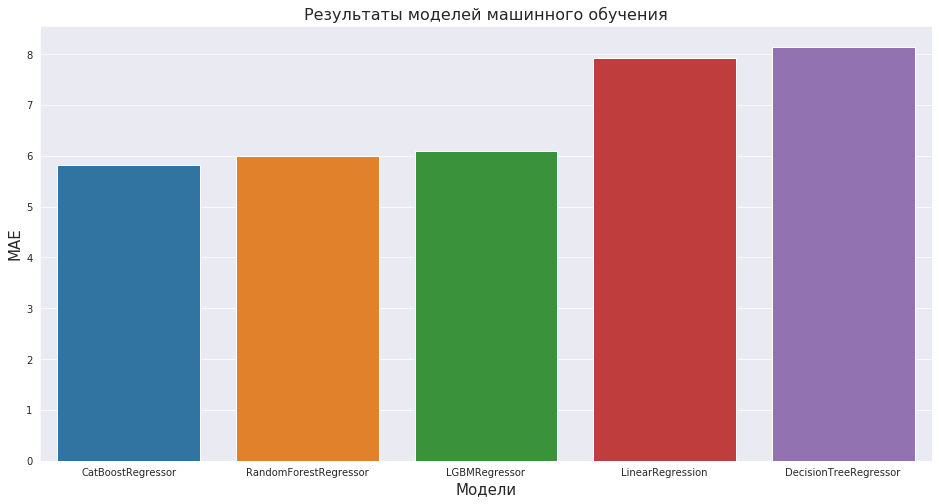

In [62]:
plt.figure(figsize=(16,8))
sns.barplot(x="Модель", y="MAE", data=res, order=res.sort_values('MAE').Модель)
plt.xlabel('Модели', fontsize=15)
plt.ylabel('MAE', fontsize=15)
plt.title('Результаты моделей машинного обучения', fontsize=16)

In [65]:
model = CatBoostRegressor(random_state = 12345)

model.fit(features_train,target_train)
predictions = model.predict(features_test)
print('MAE на тестовой выборке:', mean_absolute_error(predictions,target_test))

0:	learn: 15.9856238	total: 2.29ms	remaining: 2.28s
1:	learn: 15.7328510	total: 6.15ms	remaining: 3.07s
2:	learn: 15.4982242	total: 14.9ms	remaining: 4.94s
3:	learn: 15.2902032	total: 21.5ms	remaining: 5.35s
4:	learn: 15.0716881	total: 28.9ms	remaining: 5.75s
5:	learn: 14.8564931	total: 104ms	remaining: 17.3s
6:	learn: 14.6621068	total: 114ms	remaining: 16.2s
7:	learn: 14.4769574	total: 118ms	remaining: 14.6s
8:	learn: 14.2975922	total: 125ms	remaining: 13.8s
9:	learn: 14.1143893	total: 199ms	remaining: 19.7s
10:	learn: 13.9316195	total: 205ms	remaining: 18.5s
11:	learn: 13.7657326	total: 213ms	remaining: 17.6s
12:	learn: 13.5974003	total: 215ms	remaining: 16.4s
13:	learn: 13.4298752	total: 223ms	remaining: 15.7s
14:	learn: 13.3008807	total: 298ms	remaining: 19.6s
15:	learn: 13.1510812	total: 302ms	remaining: 18.6s
16:	learn: 13.0036926	total: 310ms	remaining: 17.9s
17:	learn: 12.8577851	total: 314ms	remaining: 17.1s
18:	learn: 12.7238242	total: 390ms	remaining: 20.1s
19:	learn: 12.590

In [74]:
def plot_feature_importance(importance,names,model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    
    plt.figure(figsize=(16,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

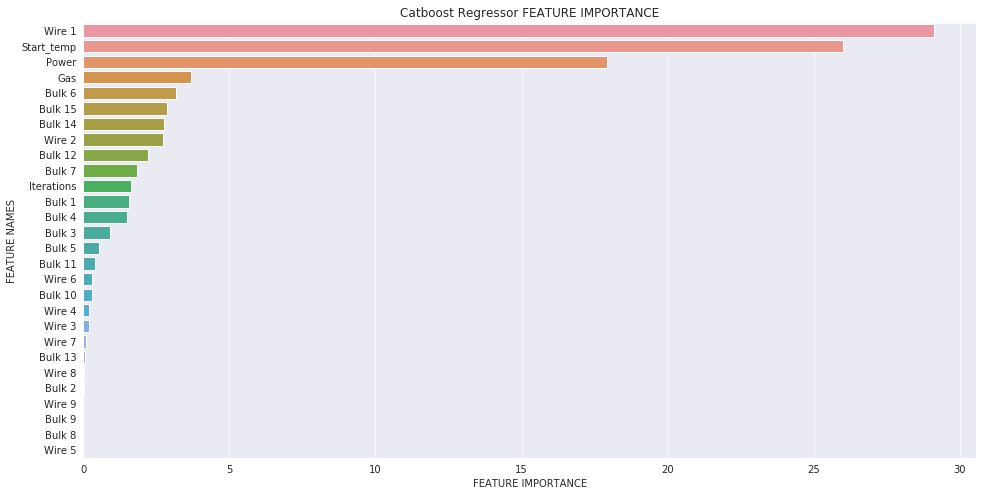

In [75]:
plot_feature_importance(model.get_feature_importance(),features_train.columns,'Catboost Regressor')

### Вывод
Применили 5 моделей обучения: CatBoost, RandomForest, LGBMRegressor, LinearRegression,Decision Tree.  Лучший показатель на тестовой выборке - 5.81 у CatBoost.



<h2>Общий вывод </h2>
<p>План работ, который был представлен на первом этапе работы с проектом выполнен в полном объеме: нам удалось свести данные в один датасет на основе номера партии, избавиться от выбросов, провести масштабирование признаков и обучить разные модели для предсказания температуры. </p>
<p>Во время работы с проектом мы:</p>
<ul>
<li>загрузили данные и изучили их</li>
<li>исправили неверные типы данных</li>
<li>ввели два новых признаков для обучения - полная мощность, время нагрева дугой</li>
<li>проверили признаки на корреляцию. Выявили, что время нагрева дугой сильно коррелирует с полной мощностью, а от объема сыпучих материалов зависит время нагрева и полная мощность. </li>
<li>провели масштабирование признаков</li>
<li>обучили несколько моделей машинного обучения, выявили наилучшую модель с показателем <b>MAE 5,8</b> (это CatBoostRegressor)</li>
<li>проверили веса признаков, от которых зависит прогнозирование целевой метрики - конечной температуры. Выявили, что начальная температура, мощность, газ и объем проволочного материала 1 - наиболее значимые признаки.</li>
</ul>


<p>Основная задача компании - уменьшение потребления электроэнергии на этапе обработки стали, не решается с помощью текущей задачи и требует дополнительных исследований. Судя по результатам данного проекта, мы видим, что один из значимых факторов - первоначальная температура стали. Необходимо задать вопросы клиенту по поводу того, как она формируется, и какие признаки влияют на первоначальную температуру. Это даст нам более полную картину, и возможно позволит указать то направление, которое необходимо прорабатывать. </p>
